### Load data

In [6]:
household_id = 'idhogar'
target_column = 'Target'

from data_cleaning import get_training_data, get_test_data
train = get_training_data()
test = get_test_data()

from column_categories import building_info
building_columns = [household_id]
building_columns.extend(building_info)
building_df = train[building_columns]

from data_cleaning import target_by_household
target_household_map = target_by_household(train)
building_df = building_df.groupby(household_id).any().astype(int)
building_df = building_df.join(target_household_map)

Loading data from data/train.csv...
(9557, 142)

Checking for inconsistent targets...
(85,)
(9557, 142)
Cleaning inconsistent targets...
Checking inconsistent targets are gone...
(0,)
(9557, 142)

Loading data from data/test.csv...
(23856, 141)



In [11]:
X = building_df.drop([target_column], axis=1)
y = building_df[target_column]

### Feature Selection

In [3]:
from sklearn.feature_selection import VarianceThreshold

In [97]:
sel = VarianceThreshold(threshold=(.75 * (1 - .75)))

In [98]:
import pandas as pd
def format_selector(selector,data, target):
    # Fit the model
    selector.fit(data, target)
    # Retain the feature names
    features = selector.get_support(indices = True)  # Returns array of indexes of nonremoved features
    features = data[[data.columns.values[i] for i in features]]
    return features

In [99]:
reduced_df = format_selector(sel, X, y)

In [100]:
from column_categories import column_descriptions
desc = {k: column_descriptions[k] for k in reduced_df}
desc

{'paredblolad': '=1 if predominant material on the outside wall is block or brick',
 'pisomoscer': '"=1 if predominant material on the floor is mosaic,  ceramic,  terrazo"',
 'cielorazo': '=1 if the house has ceiling',
 'energcocinar2': '=1 main source of energy used for cooking electricity',
 'energcocinar3': '=1 main source of energy used for cooking gas',
 'epared2': '=1 if walls are regular',
 'epared3': '=1 if walls are good',
 'etecho2': '=1 if roof are regular',
 'etecho3': '=1 if roof are good',
 'eviv3': '=1 if floor are good'}

In [101]:
def proportions(df):
    for col in df:
        df[col] =  df[col]/df[col].sum()
    return df

In [102]:
import seaborn as sns
sns.set()

def plot_breakdowns(desc):
    df = building_df[list(desc.keys())].join(target_household_map)
    if len(desc)==1:
        value = list(desc.keys())[0]
        desc['no '+value] = ''
        df['no '+value] = (~df[value].astype('bool')).astype('int')
    summed = df.groupby(target_column).sum()
    features_breakdown = proportions(summed.T).T
    features_breakdown.plot(kind='line', figsize=(12,6)).legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size':14})
    return features_breakdownn

,paredblolad,pisomoscer,cielorazo,energcocinar2,energcocinar3,epared2,epared3,etecho2,etecho3,eviv3
Target,,,,,,,,,,
1,0.095346,0.114642,0.106697,0.086266,0.131669,0.115778,0.077185,0.096481,0.080590,0.095346
2,0.092057,0.118885,0.112572,0.089953,0.117833,0.098369,0.087849,0.083640,0.096265,0.102578
3,0.105263,0.127978,0.117452,0.089751,0.100277,0.075346,0.100831,0.074238,0.094737,0.114127
4,0.118176,0.135470,0.134597,0.095642,0.070661,0.043759,0.116779,0.040003,0.116255,0.128658


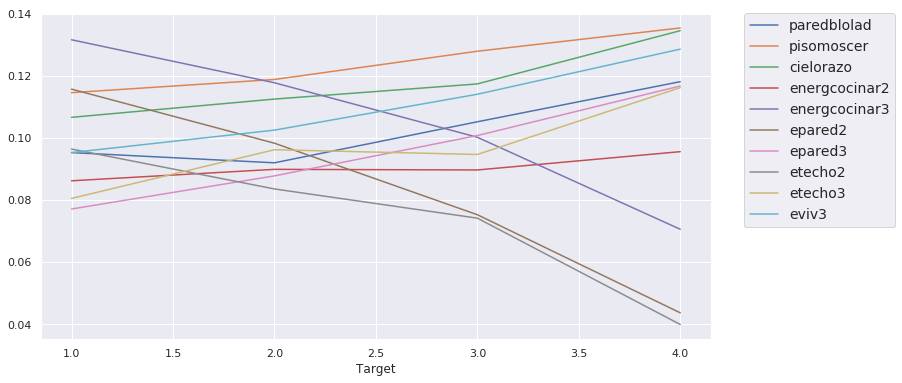

In [103]:
plot_breakdowns(desc)

### Get new training data using only slected features

In [130]:
data = building_df[list(desc.keys())].join(target_household_map)

In [131]:
X = data.drop([target_column], axis=1)
y = data[target_column]

In [132]:
from sklearn import model_selection
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y)

In [133]:
import numpy as np
from sklearn import svm
from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='linear', C=1.0)
scores = cross_val_score(clf, X, y, cv=5)
print('%.4f' % np.mean(scores))
print('%.4f' % np.std(scores))

0.6543
0.0013


In [134]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=20)
scores = cross_val_score(knn, X, y, cv=5)
print('%.4f' % np.mean(scores))
print('%.4f' % np.std(scores))

0.6349
0.0052


In [141]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 10, random_state = 42)
scores = cross_val_score(rf, X, y, cv=5)
print('%.4f' % np.mean(scores))
print('%.4f' % np.std(scores))

0.6292
0.0147


#### Try with SMOTE

In [136]:
from imblearn.over_sampling import SMOTE

print('Before OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('Before OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '2': {}".format(sum(y_train==2)))
print("Before OverSampling, counts of label '3': {}".format(sum(y_train==3)))
print("Before OverSampling, counts of label '4': {} \n".format(sum(y_train==4)))

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '2': {}".format(sum(y_train_res==2)))
print("After OverSampling, counts of label '3': {}".format(sum(y_train_res==3)))
print("After OverSampling, counts of label '4': {}".format(sum(y_train_res==4)))

Before OverSampling, the shape of train_X: (2241, 10)
Before OverSampling, the shape of train_y: (2241,) 

Before OverSampling, counts of label '1': 158
Before OverSampling, counts of label '2': 350
Before OverSampling, counts of label '3': 277
Before OverSampling, counts of label '4': 1456 

After OverSampling, the shape of train_X: (5824, 10)
After OverSampling, the shape of train_y: (5824,) 

After OverSampling, counts of label '1': 1456
After OverSampling, counts of label '2': 1456
After OverSampling, counts of label '3': 1456
After OverSampling, counts of label '4': 1456


In [137]:
clf = svm.SVC(kernel='linear', C=1.0)
clf.fit(X_train_res, y_train_res)
print('%.4f' % clf.score(X_valid, y_valid))

0.4685


In [138]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train_res, y_train_res)
print('%.4f' % knn.score(X_valid, y_valid))

0.5033


In [150]:
rf = RandomForestClassifier(n_estimators = 10)
rf.fit(X_train_res, y_train_res)
print('%.4f' % rf.score(X_valid, y_valid))

0.5556


#### SMOTE Pipeline

In [ ]:
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.combine import SMOTEENN
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

smote_enn = SMOTEENN(smote = sm)
clf_rf = RandomForestClassifier(n_estimators=25, random_state=1)

pipeline = make_pipeline(smote_enn, clf_rf)
#     OR
# pipeline = Pipeline([('smote_enn', smote_enn),
#                      ('clf_rf', clf_rf)])
param_dist = {"enn__random_state": [4,13,42],
              "enn__ratio": [0.1,0.8,0.9,0.2]}

kf = StratifiedKFold(n_splits=10)
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist,
                                   n_iter=10, 
                                   cv = kf)

In [ ]:
smote_enn.get_params().keys()

In [ ]:
from time import time
start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)